In [5]:
import numpy as np
from matplotlib import pyplot as plt
from mpi4py import MPI

# from cosmoprimo.fiducial import DESI

from pmesh.pm import ParticleMesh
from ZeNBu.zenbu import Zenbu
from ZeNBu.zenbu_rsd import Zenbu_RSD

def get_mesh_init(power, boxsize, nmesh):

    pm = ParticleMesh(BoxSize=boxsize, Nmesh=nmesh, dtype='f8', comm=MPI.COMM_WORLD)
    mesh_delta_k = pm.generate_whitenoise(seed=42, type='untransposedcomplex', unitary=True)
    norm = 1.0 / boxsize.prod()

    for kslab, delta_slab in zip(mesh_delta_k.slabs.x, mesh_delta_k.slabs):
        # the square of the norm of k on the mesh
        k2 = sum(kk**2 for kk in kslab)
        k = (k2**0.5).ravel()
        mask_nonzero = k != 0.
        tmp = np.zeros_like(k)
        tmp[mask_nonzero] = power(k[mask_nonzero])

        # multiply complex field by sqrt of power
        delta_slab[...].flat *= (tmp * norm)**0.5

    return mesh_delta_k


def shear(base):
    s2 = base.pm.create(type='real', value=0.)
    kk = base.r2c().x
    k2 = sum(ki**2 for ki in kk)
    zero_mode = (k2 == 0); nonzero = (k2 > 0)
    k2[zero_mode] = 1
    for i in range(3):
        for j in range(i, 3):
            basec = base.r2c()
            basec *= (kk[i]*kk[j] / k2 - (i == j)/3.) * nonzero
            baser = basec.c2r()
            s2[...] += baser**2
            if i != j:
                s2[...] += baser**2
    return s2


def laplace(base):
    kk = base.r2c().x
    k2 = sum(ki**2 for ki in kk)
    basec = base.r2c()
    lapc = -1*basec*k2
    return lapc.c2r()


def get_shifts(mesh_delta_k, positions=None):
    nmesh = mesh_delta_k.pm.Nmesh
    mesh_disp_r = []
    for iaxis in range(mesh_delta_k.ndim):
        psi = mesh_delta_k.copy()
        for kslab, islab, slab in zip(psi.slabs.x, psi.slabs.i, psi.slabs):
            k2 = sum(kk**2 for kk in kslab)
            k2[k2 == 0.] = 1.  # avoid dividing by zero
            mask = islab[iaxis] != nmesh[iaxis] // 2
            slab[...] *= 1j * kslab[iaxis] / k2 * mask
        psi = psi.c2r()
        if positions is not None:
            psi = psi.readout(positions, resampler='nearest')
        mesh_disp_r.append(psi)
        del psi
    if positions is not None:
        return np.column_stack(mesh_disp_r)
    return mesh_disp_r



def get_lagrangian_field(mesh_delta_r, bias, smoothing=0, positions=None):
    if smoothing > 0:

        def tf(k):
            k2 = 0
            for ki in k:
                k2 =  k2 + ki ** 2
            return np.exp(-0.5 * k2 * (smoothing**2))

        base = mesh_delta_r.r2c().apply(lambda k, v: tf(k) * v).c2r()
    else:
        base = mesh_delta_r.copy()

    #one = (base*0 + 1).copy()
    d0 = base.copy()
    d2 = 1.*base**2
    d2 -= d2.cmean()
    s2 = shear(base)
    s2 -= s2.cmean()
    lap = laplace(base)
    lap -= lap.cmean()

    mesh = 1 + sum(mesh * b for mesh, b in zip([d0, d2, s2, lap], bias))
    if positions is not None:
        mesh = mesh.readout(positions, resampler='nearest')
    return mesh


def get_pt(kv, klin, pklin, cutoff=10., f=None):
    """
    Return Zeldovich prediction.

    Parameters
    ----------
    kv : array
        Output k.

    klin : array
        Input linear k.

    pklin : array
        Output P(k).

    f : float
        Growth rate.
    """
    if f is None:  # real space
        zobj = Zenbu(klin, pklin, jn=15, N=3000, cutoff=cutoff)
        zobj.make_ptable(kvec=kv)
        tmp = zobj.pktable.T[1:]  # first is k, drop it
        pktable = np.zeros((14,) + tmp.shape[1:], dtype='f8')
        pktable[:10, ...] = tmp[:10, ...]
        pktable[10:, ...] = -kv[np.newaxis, :]**2 * tmp[[0, 1, 3, 6], ...]  # nabla
        pktable = pktable[:, None, :]
    else:
        lpt = Zenbu_RSD(klin, pklin, jn=15, N=2500, cutoff=cutoff)
        lpt.make_pltable(f, kv=kv, nmax=8, ngauss=3)

        p0table = lpt.p0ktable
        p2table = lpt.p2ktable
        p4table = lpt.p4ktable

        pktable = np.zeros((len(p0table), 3, p0table.shape[-1]))
        pktable[:, 0, :] = p0table
        pktable[:, 1, :] = p2table
        pktable[:, 2, :] = p4table
        pktable = pktable.T

    return pktable


def get_pk(pktable, b1=1., b2=0., bs=0., bk2=0.):
    """Return galaxy power spectrum prediction."""
    pktable = pktable[:14]
    bias_monomials = np.array([1,
                                2*b1, b1**2,
                                b2, b1*b2, 0.25*b2**2,
                                2*bs, 2*b1*bs, b2*bs, bs**2,
                                2*bk2, 2*bk2*b1, bk2*b2, 2*bk2*bs])

    # sum for each multipole and combine into pk
    return np.sum(bias_monomials[:, None, None] * pktable, axis=0)


import jax_cosmo as jc
from jax_cosmo import Cosmology
import jax.numpy as jnp
def linear_pk_interp(cosmo:Cosmology, a=1., n_interp=256):
    """
    Return a light emulation of the linear matter power spectrum.
    """
    k = jnp.logspace(-4, 1, n_interp)
    pk = jc.power.linear_matter_power(cosmo, k, a=a)
    pk_fn = lambda x: jc.scipy.interpolate.interp(x.reshape(-1), k, pk).reshape(x.shape)
    return pk_fn

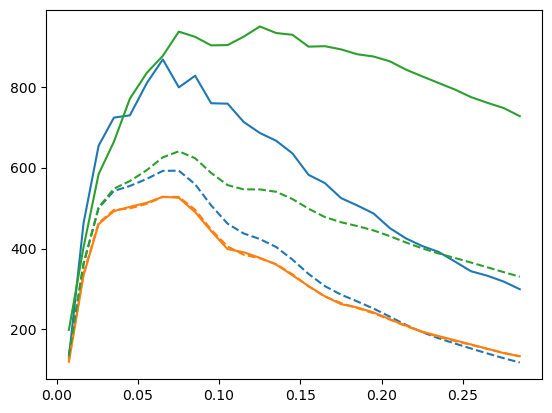

In [7]:
from jaxpm.growth import growth_factor, growth_rate
from pypower import CatalogFFTPower

z = 1
kcut = 0.3
boxsize = np.array([1000.] * 3)
nmesh = np.array([128] * 3)
klin = np.logspace(-3., 2, 1000)

fiduc_cosmo = jc.Planck15()
f = growth_rate(fiduc_cosmo, jnp.atleast_1d(1/(1+z)))
pklin = linear_pk_interp(fiduc_cosmo, 1/(1+z), n_interp=256)(klin)
k_nyquist = jnp.pi * jnp.min(nmesh / boxsize)



# pklin = DESI().get_fourier().pk_interpolator().to_1d(z=z)
# klin, pklin = pklin.k, pklin.pk

mesh_init_k = get_mesh_init(lambda k: np.interp(k, klin, pklin) * np.exp(-(k / kcut)**2), boxsize=boxsize, nmesh=nmesh)

mesh_init_r = mesh_init_k.c2r()
positions = mesh_init_r.pm.generate_uniform_particle_grid(shift=0.).copy()
shifts = get_shifts(mesh_init_k, positions=positions)
shifted_positions = positions + shifts

list_bias = [-3.,0, 3.]
list_poles, list_analytic = [], []
for b2 in list_bias:
    bias = {'b1': 0.5, 'b2': b2, 'bs': 0., 'bk2': 0.}
    weights = get_lagrangian_field(mesh_init_r, bias=list(bias.values()), smoothing=0, positions=positions)

    ells = (0,)
    kedges = np.arange(0., 0.3, 0.01)
    poles = CatalogFFTPower(data_positions1=shifted_positions, data_weights1=weights, edges=kedges, ells=ells, boxsize=boxsize, nmesh=nmesh, resampler='tsc', interlacing=3, shotnoise=0., position_type='pos', wrap=True).poles

    kv = poles.k
    #cutoff = np.pi * np.mean(nmesh / boxsize)
    #cutoff = 10.
    cutoff = kcut
    pktable = get_pt(kv, klin, pklin, cutoff=cutoff, f=None)
    analytic = get_pk(pktable, **bias)
    list_poles.append(poles)
    list_analytic.append(analytic)

ax = plt.gca()
for ibias, (poles, analytic) in enumerate(zip(list_poles, list_analytic)):
    color = 'C{:d}'.format(ibias)
    ax.plot(kv, kv * poles.power[0], color=color, linestyle='-')
    ax.plot(kv, kv * analytic[0], color=color, linestyle='--')
plt.show()